In [4]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline

# Dylan Bundy - What goes wrong?

### Data found at [Baseball Savant]( https://baseballsavant.mlb.com/statcast_search)

#### First filter on the proper rows, next on the columns **to** get data in analyzable form

In [18]:
# import data. Saved on C: drive
bd_data = pd.read_csv("C:/Users/564207/Documents/Data-Science/DataSets/files/605164_data.csv")

#drop deprecated columns with regex search
col_drop = ~bd_data.columns.str.contains("deprecated|fielder")
bd_data = bd_data.loc[:,bd_data.columns[col_drop]]

#list of additional to remove
col_drop = ['pitcher','spin_dir','p_throws','game_year','on_1b','on_2b','on_3b','inning_topbot','umpire','game_pk',
           'at_bat_number','pitch_name','bat_score','fld_score','post_home_score','post_bat_score','post_away_score',
           'des','player_name','woba_value','woba_denom','hit_location','bb_type','hc_x','hc_y','hit_distance_sc',
           'estimated_ba_using_speedangle','estimated_woba_using_speedangle','sv_id']
bd_data.drop(col_drop,axis=1,inplace=True)

event_map_dict = {'home_run':'HR','null':'nothing','strikeout':'K', 'single':'1B',
                   'field_out':'FO','hit_by_pitch':'HBP','double':'2B','field_error':'E',
                   'double_play':'DP','walk':'BB','force_out':'force_out',
                   'grounded_into_double_play':"GIDP", 'sac_bunt':'SAC Bunt', 'triple':'3B',
                   'sac_fly':'SAC Fly','caught_stealing_2b':'CS 2B', 'fielders_choice_out':'FC Out',
                   'strikeout_double_play':'SO DP', 'fielders_choice':'FC', 'intent_walk':'IBB'}
bd_data.events = bd_data.events.map(event_map_dict)

In [19]:
#dictionary for columns and null counts
col_nulls = {}

# loop through columns, drop nulls if there are any
# bad_platex = bd_data.plate_x != 'null' is basic logic
for column in bd_data.columns:
    
    if (bd_data[column].dtype == 'O') and (sum(bd_data[column] == 'null') > 0): #if null value, remove
        col_nulls[column] = sum(bd_data[column] == 'null')
        bad_col = bd_data[column] != 'null'
        bd_data = bd_data[bad_col]

# quick fix for missing data
# bad_platex = bd_data.plate_x != 'null'
# bd_data = bd_data[bad_platex]

# bad_platez = bd_data.plate_z != 'null'
# bd_data = bd_data[bad_platez]

bad_inning = bd_data.inning != 13
bd_data = bd_data[bad_inning]

col_nulls

{'babip_value': 942,
 'effective_speed': 4,
 'if_fielding_alignment': 2,
 'launch_speed': 5537,
 'launch_speed_angle': 6,
 'pitch_type': 3,
 'release_pos_x': 29,
 'release_spin_rate': 33}

In [33]:
bd_data.head(5)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,events,description,zone,game_type,...,estimated_woba_using_speedangle,babip_value,iso_value,launch_speed_angle,pitch_number,home_score,away_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
16,CH,4/11/2019,83.1,-2.443,6.2695,543257,1B,hit_into_play_no_out,4,R,...,0.727,1,0,4,2,1,4,1,Standard,Standard
21,FF,4/11/2019,92.0,-2.1853,6.3056,657656,1B,hit_into_play_no_out,12,R,...,0.543,1,0,4,5,1,2,1,Strategic,Standard
26,FF,4/11/2019,91.4,-2.4977,6.2004,595777,FO,hit_into_play,6,R,...,0.294,0,0,3,2,1,2,1,Standard,Standard
37,SL,4/11/2019,82.3,-2.534,6.1243,572039,FO,hit_into_play,6,R,...,0.026,0,0,3,3,1,0,1,Strategic,Standard
40,CH,4/11/2019,82.1,-2.4113,6.1789,543760,2B,hit_into_play_no_out,13,R,...,0.358,1,1,4,3,1,0,1,Strategic,Standard


In [16]:
#format columns as necessary
bd_data['game_date'] = pd.to_datetime(bd_data.game_date)
bd_data['plate_x'] = bd_data.plate_x.astype(np.float)
bd_data['plate_z'] = bd_data.plate_z.astype(np.float)

In [17]:
ff = bd_data[bd_data.pitch_type == 'FF'].groupby(['game_date']).agg(['mean','median','count','std'])
ff.columns

MultiIndex(levels=[['release_speed', 'batter', 'balls', 'strikes', 'plate_x', 'plate_z', 'outs_when_up', 'inning', 'sz_top', 'sz_bot', 'pitcher.1', 'pitch_number', 'home_score', 'away_score', 'post_fld_score'], ['mean', 'median', 'count', 'std']],
           labels=[[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14], [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]])

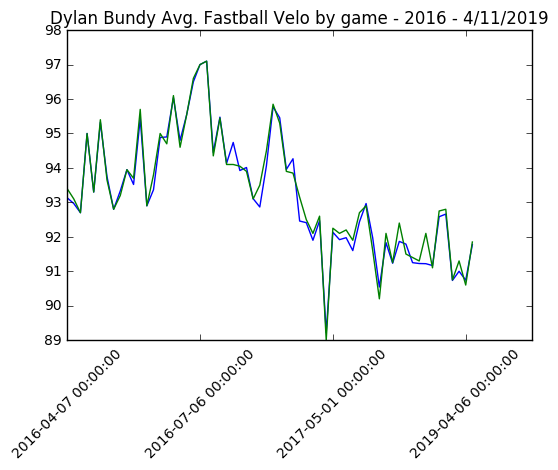

In [20]:
#plot Bundy fastball velocity over time
speed = ff['release_speed','mean']
speed2 = ff['release_speed','median']
x = range(speed.shape[0])
plt.plot(x,speed)
plt.plot(x,speed2)
labs = [ff.index[0],ff.index[20],ff.index[40],ff.index[60]]
plt.xticks([0,20,40,60],labs,rotation=45)
plt.title("Dylan Bundy Avg. Fastball Velo by game - 2016 - 4/11/2019")

# Contingency table analysis of independence based on outcome of pitches. Outcomes would be TB for each pitch to start

In [279]:
# sns.scatterplot(data=bd_data,x='plate_x',y="plate_z",hue='description',legend='brief')
# plt.legend(bbox_to_anchor=(1.6,1.2))

# facet the plots by inning. 3 rows 2 columns. Innings 1 - 6


In [20]:
bd_data.launch_speed

0       108.3
3       109.5
16       89.9
18      100.7
21       97.4
26       66.2
35      104.6
37         79
40      101.5
43       84.3
55       72.1
63       93.4
75         80
83       82.5
87         99
92      104.3
101      90.8
104      70.4
109      98.4
112     109.4
118      82.2
126      83.4
129      97.9
132      82.9
143     100.1
147      93.7
160     110.3
197        74
215        80
226      79.3
        ...  
7718     96.7
7731     95.1
7734       95
7737     76.3
7740     78.9
7743     71.9
7746     90.8
7748     62.8
7757       76
7763     95.6
7776     84.8
7778     94.4
7783       80
7788     74.5
7791     90.9
7798     75.6
7816     99.1
7817     45.5
7820    104.9
7827     96.7
7829     90.1
7834     76.1
7840     92.8
7843     87.9
7848     80.4
7851     84.1
7858     98.7
7861    108.2
7866     99.2
7868     86.9
Name: launch_speed, dtype: object